# From the github repo and modified

In [38]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
from matplotlib import pyplot as plt
from time import sleep
from IPython import display

#Custom functions
import GettingStarted_lib.general_lib as gl

# Linien imports
from linien_client.device import Device
from linien_client.connection import LinienClient
from linien_common.common import AutolockMode
from linien_common.common import  MHz, Vpp, ANALOG_OUT_V

# --------------------------------------------------------------------
# Matplotlib Inline Patch — fixes AttributeError on rcParams._get
# --------------------------------------------------------------------
import matplotlib as mpl
if not hasattr(mpl.rcParams, "_get"):
    mpl.rcParams._get = mpl.rcParams.get
# --------------------------------------------------------------------

#import matplotlib
#matplotlib.use("TkAgg")  # or "Qt5Agg"

# ----------------------------------------------
# Connection setup
# ----------------------------------------------
dev = Device(
    host="192.168.1.159",  # IP address of your Red Pitaya
    username="root",
    password="root"
)

c = LinienClient(dev)
c.connect(autostart_server=True, use_parameter_cache=True)

# Choose autolock algorithm:
#   AutolockMode.SIMPLE  -> CPU-based, faster but less robust
#   AutolockMode.ROBUST  -> FPGA-based, slower startup but stable
c.parameters.autolock_mode_preference.value = AutolockMode.ROBUST
sleep(1)  # optional short delay to ensure the setting is applied

# ----------------------------------------------
# Helper: wait until laser is locked/unlocked
# ----------------------------------------------
def wait_for_lock_status(should_be_locked):
    """Wait until the laser reaches the desired lock state."""
    counter = 0
    while True:
        print("checking lock status...")
        to_plot = pickle.loads(c.parameters.to_plot.value)

        print(f"to_plot keys: {list(to_plot.keys())}")

        is_locked = "error_signal" in to_plot

        if is_locked == should_be_locked:
            break

        counter += 1
        if counter > 10:
            raise Exception("waited too long")

        sleep(1)


# ----------------------------------------------
# Main autolock procedure
# ----------------------------------------------

# Turn off the lock (if currently running)
c.connection.root.start_sweep()
c.parameters.modulation_frequency.value = 0.05*MHz
c.parameters.modulation_amplitude.value = 0.5*Vpp
c.parameters.p.value = 2000
c.parameters.i.value = 1
c.parameters.d.value = 1
c.parameters.target_slope_rising.value = False
c.parameters.pid_on_slow_strength.value = 10
c.parameters.control_signal_history_length.value = 60

c.connection.root.write_registers()

linien_client.connection       INFO     Try to connect to 192.168.1.159:18862
linien_client.connection       DEBUG    Sent authentication hash


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


linien_client.connection       INFO     Connection established!


In [618]:
params = c.parameters
for name, param in vars(params).items():
    # Only pick those attributes that are actual Linien parameters
    if hasattr(param, "value"):
        print(f"{name}: {param.value}")

_async_changed_parameters_queue: [('autolock_watching', False), ('sweep_amplitude', 1), ('combined_offset', 0), ('pause_acquisition', False), ('autolock_retrying', False), ('autolock_failed', False), ('fetch_additional_signals', False), ('autolock_initial_sweep_amplitude', 1), ('target_slope_rising', False), ('autolock_percentage', 100), ('autolock_time_scale', 41), ('autolock_final_wait_time', 31), ('autolock_mode', <AutolockMode.ROBUST: 1>), ('lock', True), ('autolock_preparing', False), ('autolock_locked', True), ('autolock_running', False), ('ping', 894)]
to_plot: b'\x80\x04\x95\xec \x00\x00\x00\x00\x00\x00}\x94(\x8c\x0eerror_signal_1\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01M\x00\x08\x85\x94h\x05\x8c\x05dtype\x94\x93\x94\x8c\x02i2\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89B\x00\x10\x00\x00\x19\x00\x1a\x00\x1a\x00\x1a\

In [431]:
c.parameters.check_for_changed_parameters()

mod_freq_raw = c.parameters.modulation_frequency.value
mod_freq = mod_freq_raw/MHz
print(f"Modulation frequency: {mod_freq} MHz")

mod_ampl_raw = c.parameters.modulation_amplitude.value
mod_ampl = mod_ampl_raw/Vpp
print(f"Modulation amplitude: {mod_ampl} Vpp")

demod_phase = c.parameters.demodulation_phase_a.value
print(f"Demodulation phase: {demod_phase} degrees")

demod_filter_1 = c.parameters.filter_1_frequency_a.value
print(f"Demodulation filter 1: {demod_filter_1} Hz")

demod_filter_2 = c.parameters.filter_2_frequency_a.value
print(f"Demodulation filter 2: {demod_filter_2} Hz")

Modulation frequency: 0.05 MHz
Modulation amplitude: 0.5 Vpp
Demodulation phase: 150.0 degrees
Demodulation filter 1: 10000.0 Hz
Demodulation filter 2: 10000.0 Hz


In [582]:
c.parameters.offset_a.value = -75
c.connection.root.write_registers()

In [14]:
c.parameters.check_for_changed_parameters()
print("offset_a set to :", c.parameters.offset_a.value)

offset_a set to : -81.91


checking lock status...
to_plot keys: ['error_signal_1', 'monitor_signal', 'slow_control_signal']
dict_keys(['error_signal_1', 'monitor_signal', 'slow_control_signal'])


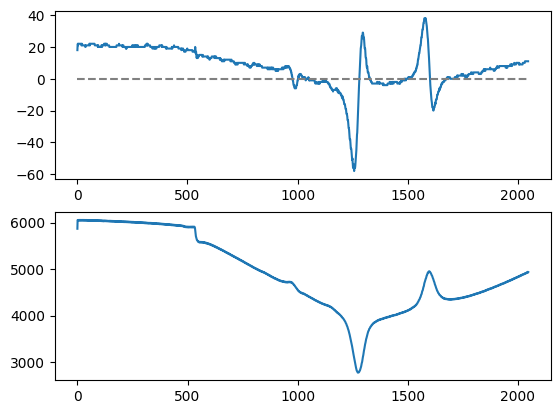

In [11]:

# Wait until the laser is unlocked
wait_for_lock_status(False)

# Record a reference spectrum
to_plot = pickle.loads(c.parameters.to_plot.value)

print(to_plot.keys())

fig,ax = plt.subplots(2,1)
ax[0].plot(to_plot["error_signal_1"], label="error_signal_1")
ax[0].hlines(0, 0, len(to_plot["error_signal_1"]), color='gray', linestyle='--')
#ax[0].set_ylim(-150,150)
ax[1].plot(to_plot["monitor_signal"], label="monitor_signal_1")

Fast variation of the control signal detected at time: [1764606148.4335544]


<Figure size 640x480 with 0 Axes>

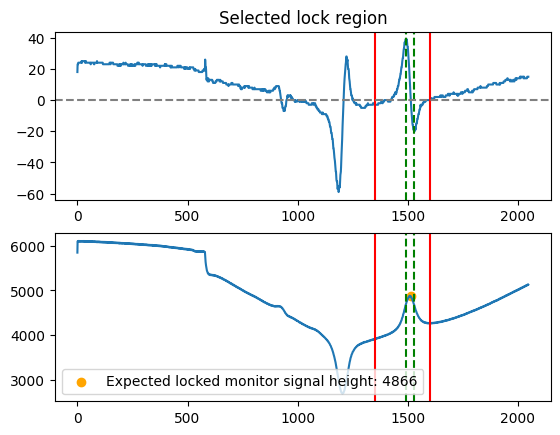

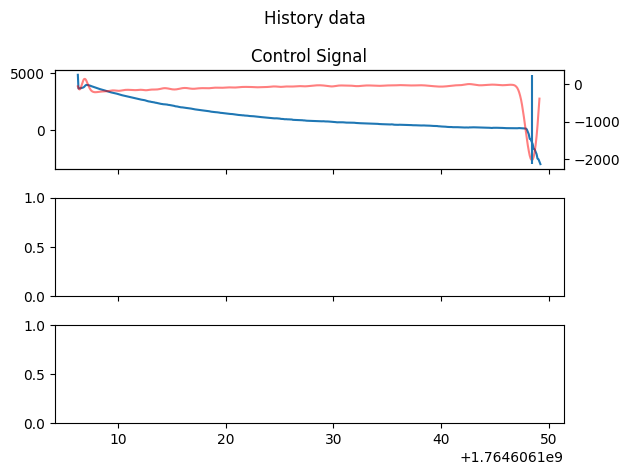

In [39]:

# Wait until the laser is unlocked
wait_for_lock_status(False)

# Record a reference spectrum
to_plot = pickle.loads(c.parameters.to_plot.value)
error_signal = to_plot["error_signal_1"]
monitor_signal = to_plot["monitor_signal"]

display.clear_output(wait=True)

# Plot the reference and monitor signals with two y-axes
fig, axs = plt.subplots(2, 1)
ax0, ax1 = axs
ax0.plot(error_signal)
ax1.plot(to_plot["monitor_signal"])
display.display(plt.gcf())

# Ask user for target line region
print("Please specify the position of the target line.")
x0 = int(input("Enter index of a point on the LEFT side of the target line: "))
x1 = int(input("Enter index of a point on the RIGHT side of the target line: "))

zero_crossing_idxs_region, monitor_signal_reference_point = gl.find_monitor_signal_reference_height(monitor_signal, error_signal, x0, x1)

# Visualize selected lock region and the expected height of the monitor signal while locked
plt.clf()
fig, axs = plt.subplots(2, 1)
ax0, ax1 = axs
ax0.plot(error_signal)
ax1.plot(to_plot["monitor_signal"])
#monitor_signal_expected_height = find_locked_monitor_signal_height(to_plot["monitor_signal"], error_signal, x0, x1)
ax0.axvline(x0, color="r")
ax0.axvline(x1, color="r")
ax1.axvline(x0, color="r")
ax1.axvline(x1, color="r")

ax0.axvline(zero_crossing_idxs_region[0], color="g", linestyle="--")
ax0.axvline(zero_crossing_idxs_region[1], color="g", linestyle="--")
ax1.axvline(zero_crossing_idxs_region[0], color="g", linestyle="--")
ax1.axvline(zero_crossing_idxs_region[1], color="g", linestyle="--")

ax0.axhline(0, color="gray", linestyle="--")

ax1.scatter(monitor_signal_reference_point[0], monitor_signal_reference_point[1], color="orange", label=f"Expected locked monitor signal height: {monitor_signal_reference_point[1]}")
ax1.legend()

ax0.set_title("Selected lock region")
display.display(plt.gcf())

# Start autolock with selected region

signal_len = len(error_signal)
print(f"Selected region: {x0}–{x1} of {signal_len} points")

if not (0 <= x0 < x1 <= signal_len):
    raise ValueError("Invalid region: indices outside range or reversed")

if x1 - x0 < 10:
    raise ValueError("Selected region too narrow — pick a wider range")

c.connection.root.start_autolock(x0, x1, pickle.dumps(error_signal))

# Wait until laser is actually locked
max_tries = 3

# for attempt in range(1, max_tries + 1):
#     print(f"Attempt {attempt}/{max_tries}: starting autolock")
#     c.connection.root.start_autolock(x0, x1, pickle.dumps(error_signal))

#     try:
#         wait_for_lock_status(True)
#         print("Locking the laser worked! \\o/")
#         gl.locking_monitor(c, monitor_signal_reference_point)
#         break
#     except Exception:
#         print("Locking the laser failed :(")
#         if attempt < max_tries:
#             print("Trying again")
#             sleep(2)
#         else:
#             print("No more tries left, starting sweep")
#             c.connection.root.start_sweep()
sleep(15)
gl.locking_monitor(c, monitor_signal_reference_point)


In [37]:
c.connection.root.start_sweep()

Signals monitor

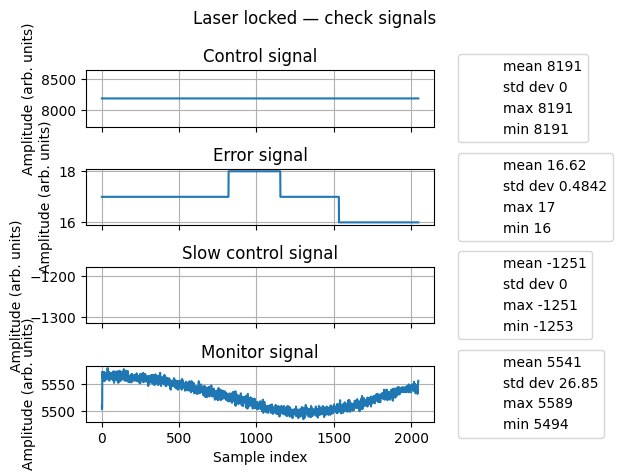

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

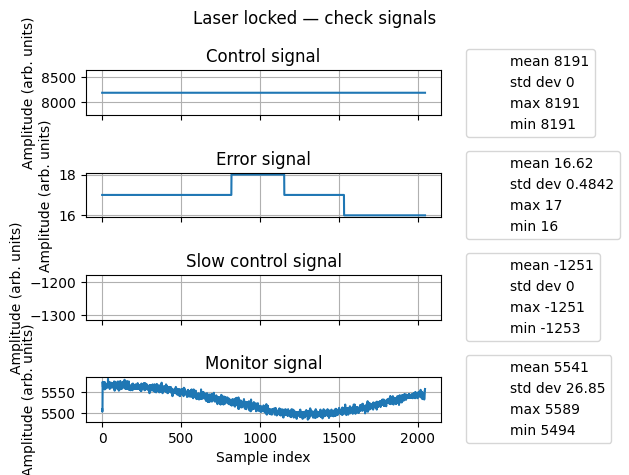

In [559]:
from IPython import display

counter = 0
limit = 5

c.parameters.check_for_changed_parameters()

while True:

    if counter >= limit:
        break

    counter +=1

    plot_data = pickle.loads(c.parameters.to_plot.value)
    #print(plot_data.keys())

    display.clear_output(wait=True)
    plt.clf()

    if c.parameters.lock.value:
        fig, ax = plt.subplots(4, 1, sharex=True, tight_layout=True)
        fig.suptitle("Laser locked — check signals")

        ax[0].set_title("Control signal")
        ax[0].plot(plot_data["control_signal"])
        ax[0].plot([], [], label = f"mean {c.parameters.signal_stats.value['control_signal_mean']:.4g}", linestyle='none')
        ax[0].plot([], [], label = f"std dev {c.parameters.signal_stats.value['control_signal_std']:.4g}", linestyle='none')
        ax[0].plot([], [], label = f"max {c.parameters.signal_stats.value['control_signal_max']:.4g}", linestyle='none')
        ax[0].plot([], [], label = f"min {c.parameters.signal_stats.value['control_signal_min']:.4g}", linestyle='none')
        
        ax[1].set_title("Error signal")
        ax[1].plot(plot_data["error_signal"])
        ax[1].plot([], [], label = f"mean {c.parameters.signal_stats.value['error_signal_mean']:.4g}", linestyle='none')
        ax[1].plot([], [], label = f"std dev {c.parameters.signal_stats.value['error_signal_std']:.4g}", linestyle='none')
        ax[1].plot([], [], label = f"max {c.parameters.signal_stats.value['error_signal_max']:.4g}", linestyle='none')
        ax[1].plot([], [], label = f"min {c.parameters.signal_stats.value['error_signal_min']:.4g}", linestyle='none')

        ax[2].set_title("Slow control signal")
        ax[2].plot(plot_data["slow_control_signal"])
        ax[2].plot([], [], label = f"mean {c.parameters.signal_stats.value['slow_control_signal_mean']:.4g}", linestyle='none')
        ax[2].plot([], [], label = f"std dev {c.parameters.signal_stats.value['slow_control_signal_std']:.4g}", linestyle='none')
        ax[2].plot([], [], label = f"max {c.parameters.signal_stats.value['slow_control_signal_max']:.4g}", linestyle='none')
        ax[2].plot([], [], label = f"min {c.parameters.signal_stats.value['slow_control_signal_min']:.4g}", linestyle='none')


        # Optional: plot the monitor signal if available
        if "monitor_signal" in plot_data:
            ax[3].set_title("Monitor signal")
            ax[3].plot(plot_data["monitor_signal"])
            ax[3].plot([], [], label = f"mean {c.parameters.signal_stats.value['monitor_signal_mean']:.4g}", linestyle='none')
            ax[3].plot([], [], label = f"std dev {c.parameters.signal_stats.value['monitor_signal_std']:.4g}", linestyle='none')
            ax[3].plot([], [], label = f"max {c.parameters.signal_stats.value['monitor_signal_max']:.4g}", linestyle='none')
            ax[3].plot([], [], label = f"min {c.parameters.signal_stats.value['monitor_signal_min']:.4g}", linestyle='none')

    else:
        fig, ax = plt.subplots(2, 1, sharex=True, tight_layout=True)
        fig.suptitle("Laser sweeping/unlocked")
        ax[0].set_title("Error signal")
        ax[0].plot(plot_data["error_signal_1"])
        #plt.plot(plot_data["error_signal_2"], label="Error signal ch2")

        # Again, include monitor signal if present
        if "monitor_signal" in plot_data:
            ax[1].set_title("Monitor signal")
            ax[1].plot(plot_data["monitor_signal"])

    for i in range(len(ax)):
        ax[i].grid(True)
        ax[i].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
        ax[i].set_ylabel('Amplitude (arb. units)')
    
    plt.xlabel('Sample index')
    display.display(plt.gcf())

    sleep(0.5)

# TESTS

In [ ]:
c.parameters.check_for_changed_parameters()
print(c.parameters.__dict__.keys())
print(c.parameters.signal_stats.value)

{'error_signal_mean': 20.50146484375, 'error_signal_std': 0.49999785422818377, 'error_signal_max': 21, 'error_signal_min': 20, 'control_signal_mean': 8191.0, 'control_signal_std': 0.0, 'control_signal_max': 8191, 'control_signal_min': 8191, 'monitor_signal_mean': 5308.04150390625, 'monitor_signal_std': 27.529099236435542, 'monitor_signal_max': 5358, 'monitor_signal_min': 5262, 'slow_control_signal_mean': -4313.0, 'slow_control_signal_std': 0.0, 'slow_control_signal_max': -4313, 'slow_control_signal_min': -4313}


In [629]:
# def plot_history(c):
#     counter = 0
#     limit = 200

#     c.parameters.check_for_changed_parameters()

#     while True:

#         #if counter >= limit:
#             #break

#         counter +=1

#         control_history = c.parameters.control_signal_history.value
#         signal_history = c.parameters.monitor_signal_history.value

#         display.clear_output(wait=True)
#         plt.clf()

#         fig, axs = plt.subplots(3,1, sharex=True, tight_layout=True)
#         fig.suptitle("History data")

#         ax0, ax1, ax2 = axs

#         ax0.set_title("Control Signal")
#         ax0.plot(control_history["times"], control_history["values"])

#         ax1.set_title("Slow Control Signal")
#         ax1.plot(control_history["slow_times"], control_history["slow_values"])

#         ax2.set_title("Monitor Signal")
#         ax2.plot(signal_history["times"], signal_history["values"])

#         display.display(plt.gcf())

#         sleep(2)

# def find_locked_monitor_signal_height(monitor_signal, error_signal, x0, x1):
#     monitor_signal_selected_region = monitor_signal[x0:x1]
#     expected_height = 
#     print(f"Estimated locked monitor signal height: {expected_height:.4g}")
#     return expected_height